Столбцы в данных:
['time_period', 'time_identifier', 'geographic_level', 'country_code', 'country_name', 'version', 'characteristic_type', 'characteristic_value', 'exam_cohort', 'level_of_study', 'student_count_year_1', 'student_count_year_2', 'retained', 'retained_and_assessed', 'returned_and_retained', 'perc_retained', 'perc_retained_and_assessed', 'perc_returned_and_retained']

Размер данных: (1850, 18)

Первые 3 строки:
   time_period time_identifier geographic_level country_code country_name  \
0       201920   Academic year         National    E92000001      England   
1       202021   Academic year         National    E92000001      England   
2       202122   Academic year         National    E92000001      England   

   version characteristic_type characteristic_value exam_cohort  \
0    Final                 Sex               Female     A level   
1    Final                 Sex               Female     A level   
2  Revised                 Sex               Female     A leve

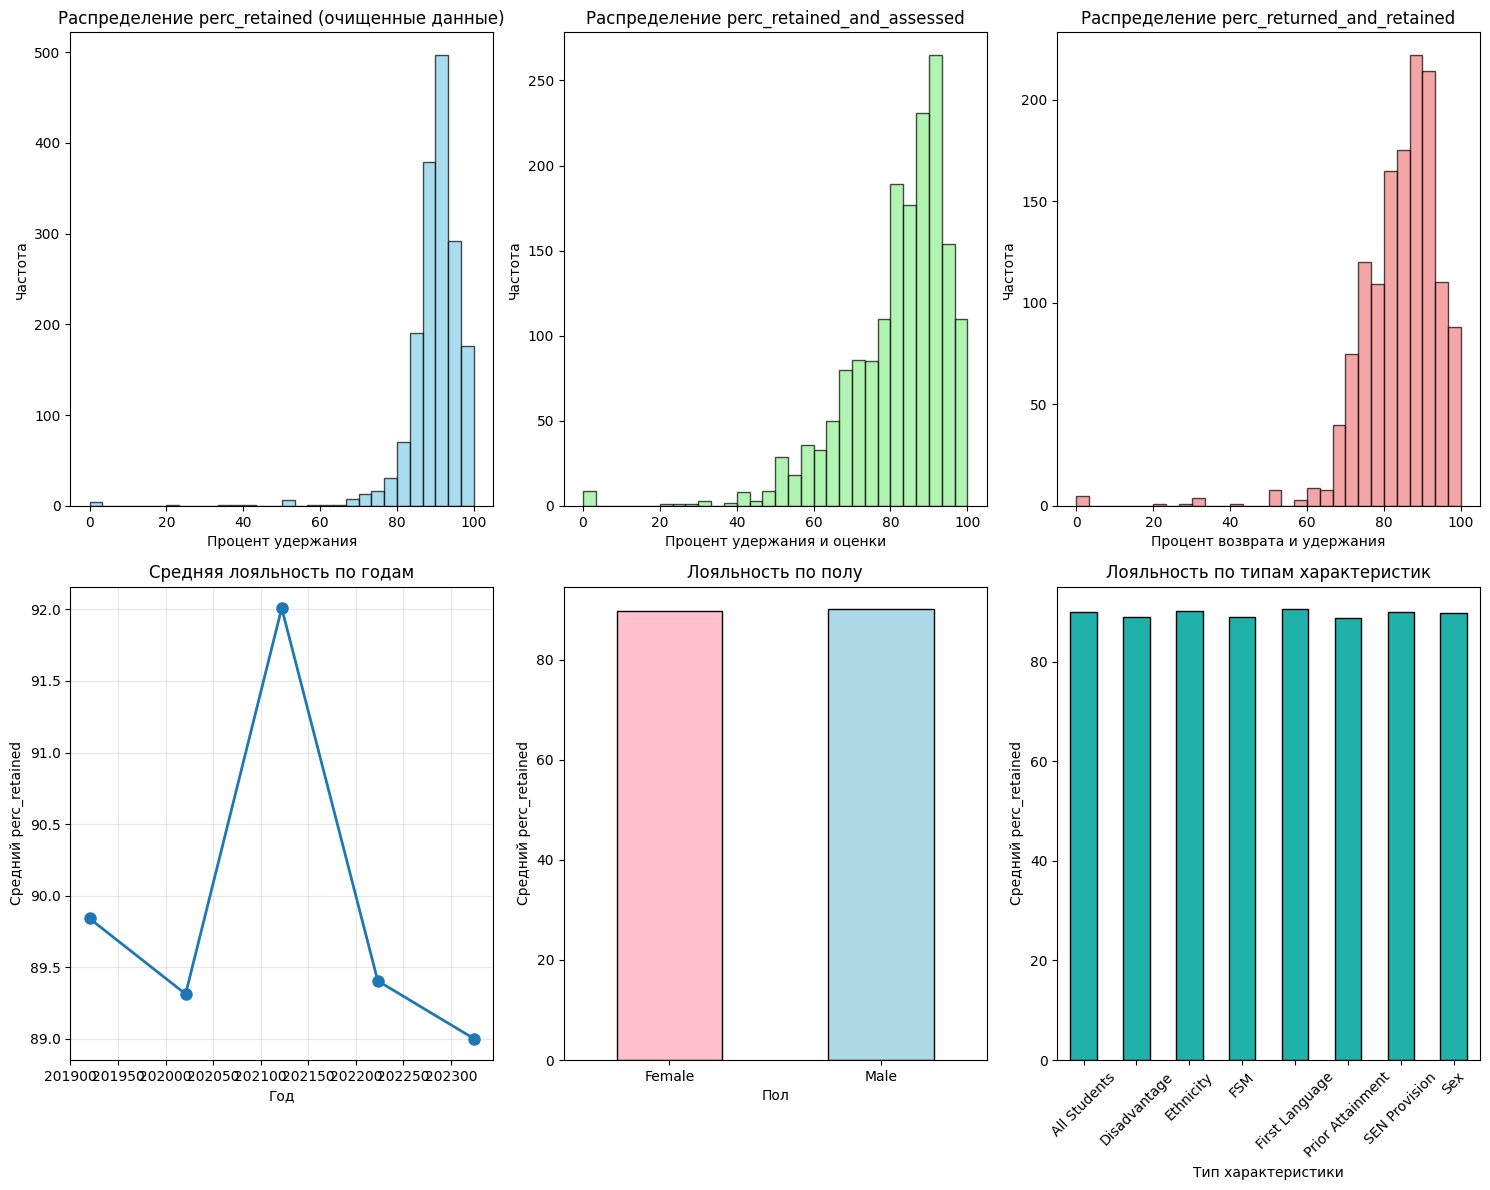

Числовые столбцы для корреляции: ['time_period', 'student_count_year_1', 'student_count_year_2', 'retained', 'retained_and_assessed', 'returned_and_retained', 'perc_retained', 'perc_retained_and_assessed', 'perc_returned_and_retained']


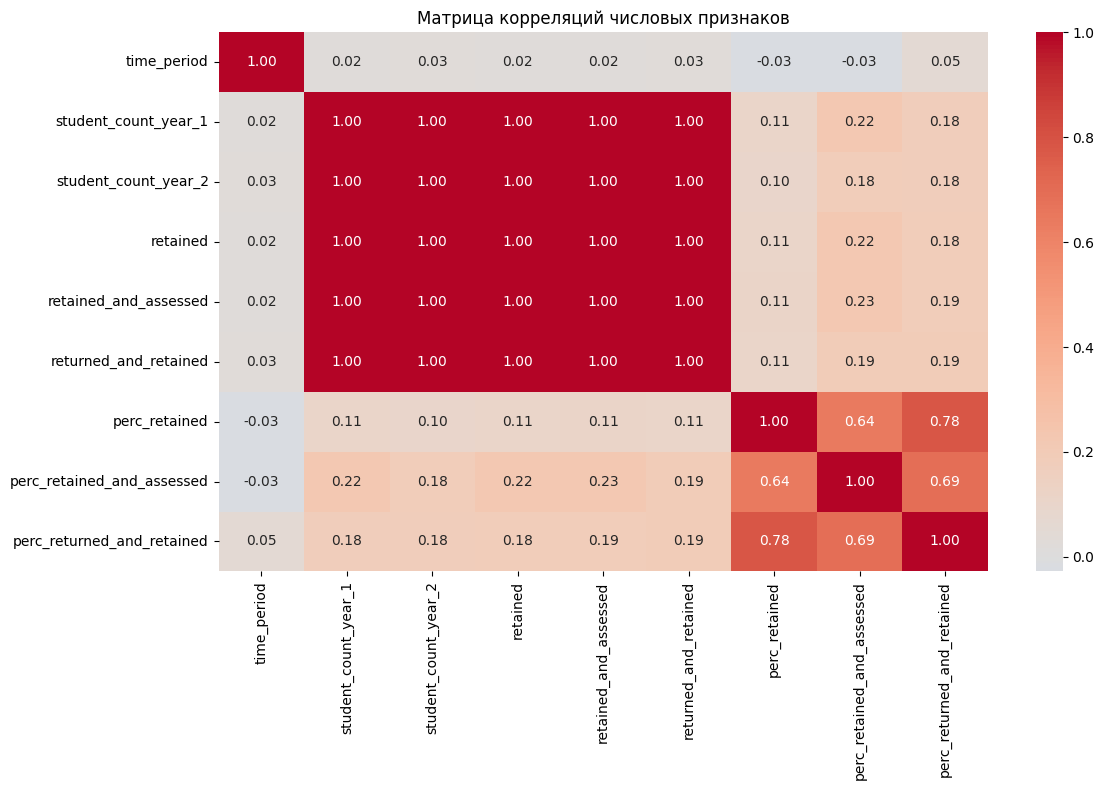


Топ 5 групп с самой высокой лояльностью:
     characteristic_type                               characteristic_value  \
1431           Ethnicity                   Asian or Asian British - Chinese   
1406           Ethnicity                White - Traveller of Irish Heritage   
1405           Ethnicity                White - Traveller of Irish Heritage   
800        SEN Provision  EHC plans and statements of SEN- Multi-sensory...   
525        SEN Provision  SEN support- Profound and multiple learning di...   

          exam_cohort  perc_retained  
1431       Tech level          100.0  
1406       Tech level          100.0  
1405       Tech level          100.0  
800   Applied general          100.0  
525          Academic          100.0  

Топ 5 групп с самой низкой лояльностью:
     characteristic_type                               characteristic_value  \
1266       SEN Provision  SEN support- Profound and multiple learning di...   
1776           Ethnicity                White - Tr

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
import warnings


#Работу выполнил:
#Студент 4 курса бакалавриата ЧОУ МУИВ
#группы ИСс 23.1/Б3-22
#Червоный Иван Андреевич 


warnings.filterwarnings('ignore')

df = pd.read_csv('./a-level-and-other-16-to-18-results_2023-24/data/retention_by_characteristic_202024.csv')

print("Столбцы в данных:")
print(df.columns.tolist())
print(f"\nРазмер данных: {df.shape}")

print("\nПервые 3 строки:")
print(df.head(3))

print("\nТипы данных:")
print(df.dtypes)

percent_columns = ['perc_retained', 'perc_retained_and_assessed', 'perc_returned_and_retained']

print("\nПримеры проблемных данных в perc_retained:")
print(df['perc_retained'].head(10))

# Очистка данных от мусора
def clean_percentage_column(series):
    cleaned = []
    for value in series:
        if isinstance(value, str):
            cleaned_value = ''.join(char for char in value if char.isdigit() or char == '.')
            if cleaned_value and cleaned_value != '.':
                try:
                    cleaned.append(float(cleaned_value))
                except:
                    cleaned.append(np.nan)
            else:
                cleaned.append(np.nan)
        else:
            cleaned.append(float(value))
    return cleaned

for col in percent_columns:
    if col in df.columns:
        df[col] = clean_percentage_column(df[col])
        print(f"Очищен столбец {col}")

# Преобразование числовых столбцов, хранящихся как object
numeric_object_cols = ['student_count_year_2', 'retained', 'retained_and_assessed', 'returned_and_retained']
for col in numeric_object_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

# Удаление дубликатов по ключевым полям, оставляя приоритет 'Revised' над 'Final'
df = df.sort_values('version').drop_duplicates(
    subset=['time_period', 'characteristic_type', 'characteristic_value', 'exam_cohort'],
    keep='last'
)

df_clean = df.dropna(subset=['perc_retained']).copy()
print(f"\nРазмер данных после очистки: {df_clean.shape}")

print("\nСтатистика после очистки:")
print(df_clean[percent_columns].describe())

categorical_cols = []
for col in df_clean.columns:
    if df_clean[col].dtype == 'object':
        categorical_cols.append(col)

print(f"\nКатегориальные столбцы: {categorical_cols}")

for col in categorical_cols:
    print(f"{col}: {df_clean[col].unique()[:10]}") 
    print(f"Количество уникальных: {df_clean[col].nunique()}")

plt.figure(figsize=(15, 12))

plt.subplot(2, 3, 1)
plt.hist(df_clean['perc_retained'], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
plt.title('Распределение perc_retained (очищенные данные)')
plt.xlabel('Процент удержания')
plt.ylabel('Частота')

plt.subplot(2, 3, 2)
plt.hist(df_clean['perc_retained_and_assessed'], bins=30, alpha=0.7, color='lightgreen', edgecolor='black')
plt.title('Распределение perc_retained_and_assessed')
plt.xlabel('Процент удержания и оценки')
plt.ylabel('Частота')

plt.subplot(2, 3, 3)
plt.hist(df_clean['perc_returned_and_retained'], bins=30, alpha=0.7, color='lightcoral', edgecolor='black')
plt.title('Распределение perc_returned_and_retained')
plt.xlabel('Процент возврата и удержания')
plt.ylabel('Частота')

plt.subplot(2, 3, 4)
yearly_retention = df_clean.groupby('time_period')['perc_retained'].mean()
plt.plot(yearly_retention.index, yearly_retention.values, marker='o', linewidth=2, markersize=8)
plt.title('Средняя лояльность по годам')
plt.xlabel('Год')
plt.ylabel('Средний perc_retained')
plt.grid(True, alpha=0.3)

if 'characteristic_type' in df_clean.columns:
    sex_data = df_clean[df_clean['characteristic_type'] == 'Sex']
    if not sex_data.empty:
        plt.subplot(2, 3, 5)
        sex_retention = sex_data.groupby('characteristic_value')['perc_retained'].mean()
        colors = ['pink', 'lightblue'] if len(sex_retention) == 2 else ['lightblue']
        sex_retention.plot(kind='bar', color=colors, edgecolor='black')
        plt.title('Лояльность по полу')
        plt.xlabel('Пол')
        plt.ylabel('Средний perc_retained')
        plt.xticks(rotation=0)

plt.subplot(2, 3, 6)
characteristic_retention = df_clean.groupby('characteristic_type')['perc_retained'].mean()
characteristic_retention.plot(kind='bar', color='lightseagreen', edgecolor='black')
plt.title('Лояльность по типам характеристик')
plt.xlabel('Тип характеристики')
plt.ylabel('Средний perc_retained')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

numeric_cols = df_clean.select_dtypes(include=[np.number]).columns.tolist()
print(f"Числовые столбцы для корреляции: {numeric_cols}")

plt.figure(figsize=(12, 8))
correlation_matrix = df_clean[numeric_cols].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Матрица корреляций числовых признаков')
plt.tight_layout()
plt.show()

print("\nТоп 5 групп с самой высокой лояльностью:")
high_retention = df_clean.nlargest(5, 'perc_retained')[['characteristic_type', 'characteristic_value', 'exam_cohort', 'perc_retained']]
print(high_retention)

print("\nТоп 5 групп с самой низкой лояльностью:")
low_retention = df_clean.nsmallest(5, 'perc_retained')[['characteristic_type', 'characteristic_value', 'exam_cohort', 'perc_retained']]
print(low_retention)

In [5]:
# Предобработка данных
def prepare_vae_data(df):

    # Копирование очищенных данных
    data = df.copy()
    
    # Числовые признаки
    numeric_features = [
        'time_period', 
        'student_count_year_1'
    ]
    
    # Важные категориальные признаки
    categorical_features = [
        'characteristic_type', 
        'characteristic_value', 
        'exam_cohort',
        'level_of_study',
        'version'
    ]
    
    # Категориальные признаки
    label_encoders = {}
    for col in categorical_features:
        le = LabelEncoder()
        data[col + '_encoded'] = le.fit_transform(data[col].astype(str))
        label_encoders[col] = le
        numeric_features.append(col + '_encoded')
    
    # Целевая переменная для анализа
    target = data['perc_retained'].values
    
    # Признаки для VAE
    features = data[numeric_features].values
    
    # Нормализация
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)
    
    return features_scaled, target, scaler, label_encoders, numeric_features

# Подготовка данных
features, target, scaler, label_encoders, feature_names = prepare_vae_data(df_clean)

print(f"Размерность признаков: {features.shape}")
print(f"Используемые признаки: {feature_names}")

# Разделение на train/test
X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.2, random_state=42, stratify=pd.cut(target, bins=5)
)

print(f"Train size: {X_train.shape}, Test size: {X_test.shape}")

# Создание DataLoader
batch_size = 32
train_dataset = TensorDataset(torch.FloatTensor(X_train))
test_dataset = TensorDataset(torch.FloatTensor(X_test))

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Размерность признаков: (1690, 7)
Используемые признаки: ['time_period', 'student_count_year_1', 'characteristic_type_encoded', 'characteristic_value_encoded', 'exam_cohort_encoded', 'level_of_study_encoded', 'version_encoded']
Train size: (1352, 7), Test size: (338, 7)


In [6]:
# Предобработка данных с проверкой на NaN и inf
def prepare_vae_data(df):
    # Копирование очищенных данных
    data = df.copy()
    
    # Создание безопасных производных признаков без утечки
    data['enrollment_change'] = data['student_count_year_2'] / (data['student_count_year_1'] + 1e-8)
    data['assessment_rate'] = np.where(
        data['retained'] > 0,
        data['retained_and_assessed'] / (data['retained'] + 1e-8),
        0
    )
    
    # Группировка редких категорий в characteristic_value
    top_values = data['characteristic_value'].value_counts().head(15).index
    data['characteristic_value_grouped'] = data['characteristic_value'].apply(
        lambda x: x if x in top_values else 'Other'
    )
    
    # Разделение признаков на числовые и категориальные
    numeric_features = [
        'time_period', 
        'student_count_year_1',
        'enrollment_change',
        'assessment_rate'
    ]
    
    categorical_features = [
        'characteristic_type', 
        'characteristic_value_grouped',
        'exam_cohort',
        'level_of_study',
        'version'
    ]
    
    # Кодирование категориальных признаков
    label_encoders = {}
    categorical_scaled = []
    
    for col in categorical_features:
        le = LabelEncoder()
        encoded_col = le.fit_transform(data[col].astype(str))
        # Масштабирование категориальных признаков в диапазон [0, 1]
        if len(np.unique(encoded_col)) > 1:
            scaled_col = encoded_col / (len(np.unique(encoded_col)) - 1)
        else:
            scaled_col = encoded_col.astype(float)
        categorical_scaled.append(scaled_col)
        label_encoders[col] = le
    
    # Нормализация числовых признаков
    scaler = StandardScaler()
    numeric_scaled = scaler.fit_transform(data[numeric_features])
    
    # Объединение всех признаков
    features = np.column_stack([numeric_scaled] + categorical_scaled)
    
    # УДАЛЕНИЕ СТРОК С NaN ИЛИ БЕСКОНЕЧНЫМИ ЗНАЧЕНИЯМИ
    valid_mask = np.isfinite(features).all(axis=1)
    features = features[valid_mask]
    target = data['perc_retained'].values[valid_mask]
    
    # Обновлённый список имён признаков
    feature_names = numeric_features + [col + '_encoded' for col in categorical_features]
    
    print(f"Удалено строк с некорректными значениями: {len(data) - len(features)}")
    
    return features, target, scaler, label_encoders, feature_names

# Подготовка данных
features, target, scaler, label_encoders, feature_names = prepare_vae_data(df_clean)

print(f"Размерность признаков: {features.shape}")
print(f"Используемые признаки: {feature_names}")

# Разделение на train/test
X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.2, random_state=42, stratify=pd.cut(target, bins=5, duplicates='drop')
)

print(f"Train size: {X_train.shape}, Test size: {X_test.shape}")

# Создание DataLoader
batch_size = 32
train_dataset = TensorDataset(torch.FloatTensor(X_train))
test_dataset = TensorDataset(torch.FloatTensor(X_test))

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Удалено строк с некорректными значениями: 332
Размерность признаков: (1358, 9)
Используемые признаки: ['time_period', 'student_count_year_1', 'enrollment_change', 'assessment_rate', 'characteristic_type_encoded', 'characteristic_value_grouped_encoded', 'exam_cohort_encoded', 'level_of_study_encoded', 'version_encoded']
Train size: (1086, 9), Test size: (272, 9)


Запуск обучения
Параметры:
 - Epochs: 200
 - Learning rate: 0.001
 - Free bits threshold: 0.5
 - Latent dimension: 1
 - Parameters: 379
Новая лучшая модель! Epoch: 0, Test Loss: 168.3816
Epoch   0: Train Loss: 200.1538, Test Loss: 168.3816, Recon: 199.5953, KL: 0.5585, KL/Recon: 0.00
Новая лучшая модель! Epoch: 1, Test Loss: 143.4653
Новая лучшая модель! Epoch: 2, Test Loss: 128.6225
Новая лучшая модель! Epoch: 3, Test Loss: 123.5757
Новая лучшая модель! Epoch: 4, Test Loss: 116.4917
Новая лучшая модель! Epoch: 5, Test Loss: 111.5881
Новая лучшая модель! Epoch: 6, Test Loss: 106.7246
Новая лучшая модель! Epoch: 7, Test Loss: 101.0530
Новая лучшая модель! Epoch: 8, Test Loss: 98.9940
Новая лучшая модель! Epoch: 9, Test Loss: 96.0552
Новая лучшая модель! Epoch: 10, Test Loss: 94.7366
Epoch  10: Train Loss: 110.8023, Test Loss: 94.7366, Recon: 93.5768, KL: 17.2255, KL/Recon: 0.18
Новая лучшая модель! Epoch: 11, Test Loss: 92.0687
Новая лучшая модель! Epoch: 12, Test Loss: 89.9098
Новая лу

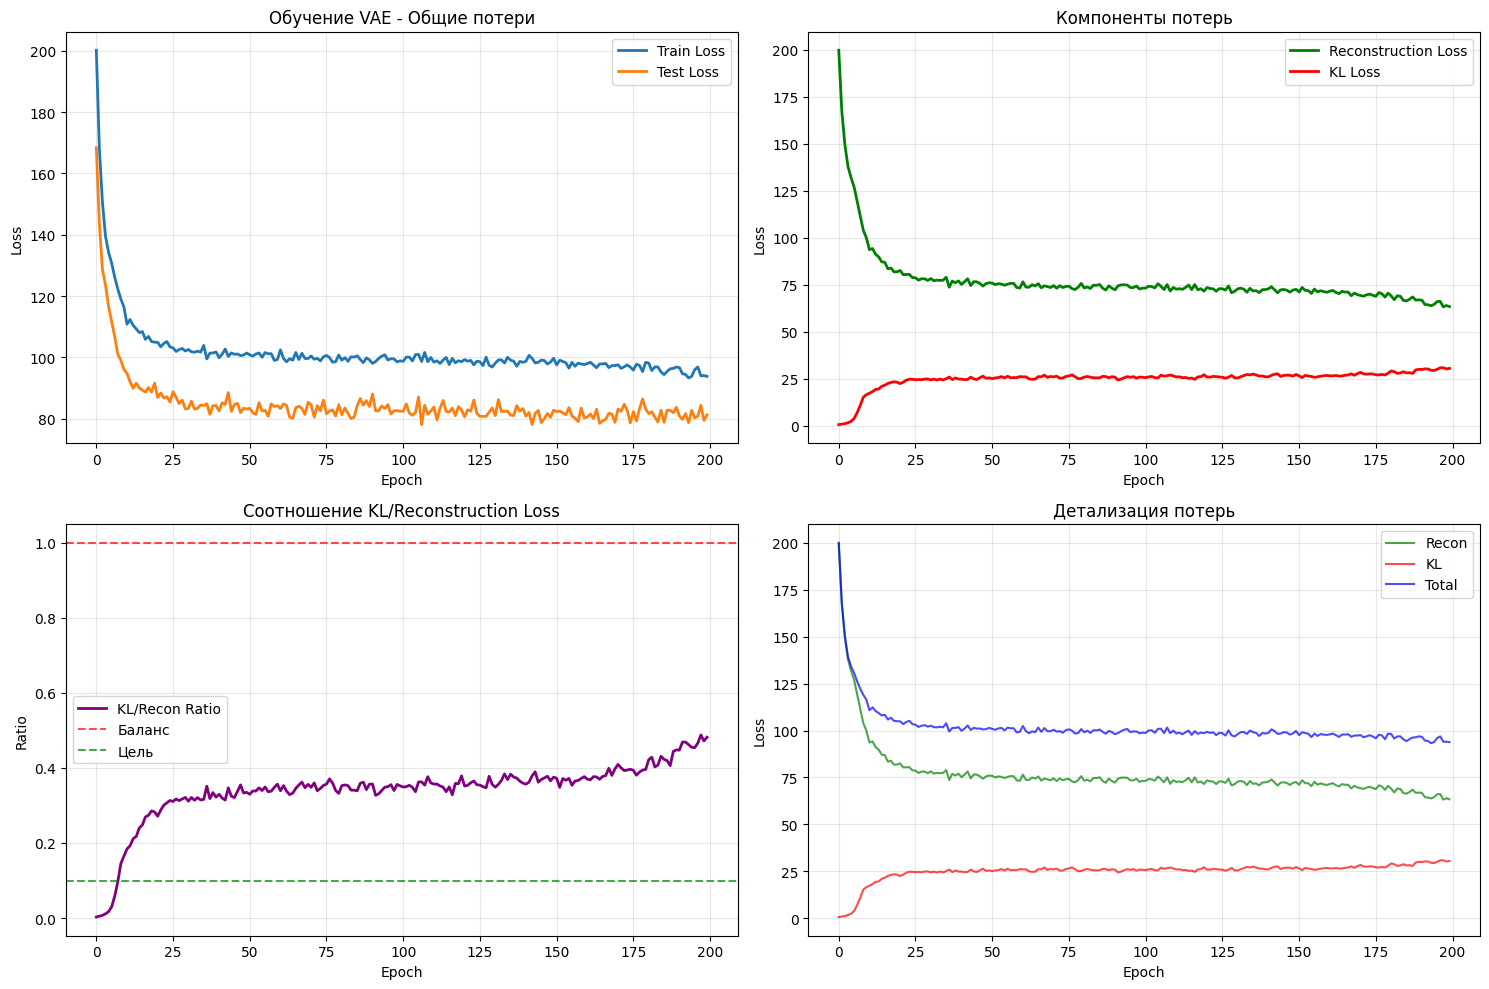

Результаты:
 - Лучший Test Loss: 78.0487
 - Final Reconstruction Loss: 63.3014
 - Final KL Loss: 30.4891
 - Final KL/Recon Ratio: 0.48

Архитектура:
 - Входная размерность: 9
 - Латентная размерность: 1
 - Скрытый слой: 16 нейронов
 - Всего параметров: 379

Сохраненные файлы:
student_model_vae_best.pth - лучшая модель
student_model_vae_final.pth - финальная модель
student_model_vae_history.pth - история обучения
vae_final_training_results.png - графики обучения


In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
import warnings
warnings.filterwarnings('ignore')

class StudentVAE(nn.Module):
    
    # Архитектура VAE для данных студентов
    
    def __init__(self, input_dim, hidden_dim=16, latent_dim=1):
        super(StudentVAE, self).__init__()
        
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        
        # Энкодер
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
        )
        
        # Латентное пространство
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)
        
        # Декодер
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim)
        )
        
    def encode(self, x):
        h = self.encoder(x)
        return self.fc_mu(h), self.fc_logvar(h)
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z):
        return self.decoder(z)
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

def vae_loss_free_bits(recon_x, x, mu, logvar, free_bits_threshold=0.5):
    # Free Bits VAE loss function для предотвращения collapse латентного пространства
    
    # Reconstruction loss (MSE без дополнительного масштабирования)
    recon_loss = nn.MSELoss(reduction='sum')(recon_x, x)
    
    # KL divergence with numerical stability
    kl_per_latent = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=0)
    kl_loss = torch.sum(torch.clamp(kl_per_latent, min=free_bits_threshold))
    
    total_loss = recon_loss + kl_loss
    
    return total_loss, recon_loss, kl_loss

def train_final_vae(model, train_loader, test_loader, epochs=200, lr=1e-3, free_bits=0.5, model_name='student_vae_final'):
    # Функция обучения VAE
    
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    # История обучения
    train_losses = []
    test_losses = []
    recon_losses = []
    kl_losses = []
    kl_recon_ratios = []
    
    best_test_loss = float('inf')
    best_epoch = 0
    
    print("Запуск обучения")
    print(f"Параметры:")
    print(f" - Epochs: {epochs}")
    print(f" - Learning rate: {lr}")
    print(f" - Free bits threshold: {free_bits}")
    print(f" - Latent dimension: {model.latent_dim}")
    print(f" - Parameters: {sum(p.numel() for p in model.parameters()):,}")
    
    for epoch in range(epochs):
        # Обучение 
        model.train()
        train_loss = 0
        recon_loss_train = 0
        kl_loss_train = 0
        batch_count = 0
        
        for batch in train_loader:
            x = batch[0]
            optimizer.zero_grad()
            
            recon_batch, mu, logvar = model(x)
            loss, recon_loss, kl_loss = vae_loss_free_bits(recon_batch, x, mu, logvar, free_bits)
            
            loss.backward()
            # Gradient clipping for stability
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            train_loss += loss.item()
            recon_loss_train += recon_loss.item()
            kl_loss_train += kl_loss.item()
            batch_count += 1
        
        # Средние значения за эпоху
        avg_train_loss = train_loss / batch_count if batch_count > 0 else float('nan')
        avg_recon = recon_loss_train / batch_count if batch_count > 0 else float('nan')
        avg_kl = kl_loss_train / batch_count if batch_count > 0 else float('nan')
        kl_recon_ratio = avg_kl / avg_recon if avg_recon > 0 and not np.isnan(avg_recon) else 0
        
        # Валидация 
        model.eval()
        test_loss = 0
        test_batch_count = 0
        
        with torch.no_grad():
            for batch in test_loader:
                x = batch[0]
                recon_batch, mu, logvar = model(x)
                loss, _, _ = vae_loss_free_bits(recon_batch, x, mu, logvar, free_bits)
                test_loss += loss.item()
                test_batch_count += 1
        
        avg_test_loss = test_loss / test_batch_count if test_batch_count > 0 else float('nan')
        
        # Сохранение истории
        train_losses.append(avg_train_loss)
        test_losses.append(avg_test_loss)
        recon_losses.append(avg_recon)
        kl_losses.append(avg_kl)
        kl_recon_ratios.append(kl_recon_ratio)
        
        if not np.isnan(avg_test_loss) and avg_test_loss < best_test_loss:
            best_test_loss = avg_test_loss
            best_epoch = epoch
            
            best_model_state = {
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train_loss': avg_train_loss,
                'test_loss': avg_test_loss,
                'recon_loss': avg_recon,
                'kl_loss': avg_kl,
                'kl_recon_ratio': kl_recon_ratio,
                'model_architecture': {
                    'input_dim': model.input_dim,
                    'latent_dim': model.latent_dim,
                    'hidden_dim': 16  
                }
            }
            
            torch.save(best_model_state, f'{model_name}_best.pth')
            print(f'Новая лучшая модель! Epoch: {epoch}, Test Loss: {avg_test_loss:.4f}')
        
        if epoch % 10 == 0:
            print(f'Epoch {epoch:3d}: '
                  f'Train Loss: {avg_train_loss:.4f}, '
                  f'Test Loss: {avg_test_loss:.4f}, '
                  f'Recon: {avg_recon:.4f}, '
                  f'KL: {avg_kl:.4f}, '
                  f'KL/Recon: {kl_recon_ratio:.2f}')
    
    final_model_state = {
        'epoch': epochs,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_loss': avg_train_loss,
        'test_loss': avg_test_loss,
        'recon_loss': avg_recon,
        'kl_loss': avg_kl,
        'kl_recon_ratio': kl_recon_ratio,
        'training_history': {
            'train_losses': train_losses,
            'test_losses': test_losses,
            'recon_losses': recon_losses,
            'kl_losses': kl_losses,
            'kl_recon_ratios': kl_recon_ratios
        },
        'model_architecture': {
            'input_dim': model.input_dim,
            'latent_dim': model.latent_dim,
            'hidden_dim': 16
        }
    }
    
    torch.save(final_model_state, f'{model_name}_final.pth')
    
    # История обучения отдельно
    training_history = {
        'train_losses': train_losses,
        'test_losses': test_losses,
        'recon_losses': recon_losses,
        'kl_losses': kl_losses,
        'kl_recon_ratios': kl_recon_ratios,
        'best_epoch': best_epoch,
        'best_test_loss': best_test_loss
    }
    
    torch.save(training_history, f'{model_name}_history.pth')
    
    return train_losses, test_losses, recon_losses, kl_losses, kl_recon_ratios

def plot_training_results(train_losses, test_losses, recon_losses, kl_losses, kl_recon_ratios):

    plt.figure(figsize=(15, 10))
    
    # Общие потери
    plt.subplot(2, 2, 1)
    plt.plot(train_losses, label='Train Loss', linewidth=2)
    plt.plot(test_losses, label='Test Loss', linewidth=2)
    plt.title('Обучение VAE - Общие потери')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Компоненты потерь
    plt.subplot(2, 2, 2)
    plt.plot(recon_losses, label='Reconstruction Loss', color='green', linewidth=2)
    plt.plot(kl_losses, label='KL Loss', color='red', linewidth=2)
    plt.title('Компоненты потерь')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Соотношение KL/Recon
    plt.subplot(2, 2, 3)
    plt.plot(kl_recon_ratios, label='KL/Recon Ratio', color='purple', linewidth=2)
    plt.axhline(y=1.0, color='red', linestyle='--', alpha=0.7, label='Баланс')
    plt.axhline(y=0.1, color='green', linestyle='--', alpha=0.7, label='Цель')
    plt.title('Соотношение KL/Reconstruction Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Ratio')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Детализированный вид
    plt.subplot(2, 2, 4)
    plt.plot(recon_losses, label='Recon', color='green', alpha=0.7)
    plt.plot(kl_losses, label='KL', color='red', alpha=0.7)
    plt.plot(train_losses, label='Total', color='blue', alpha=0.7)
    plt.title('Детализация потерь')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('vae_final_training_results.png', dpi=300, bbox_inches='tight')
    plt.show()

def print_final_report(model, train_losses, test_losses, recon_losses, kl_losses, kl_recon_ratios):
    
    # Финальный отчет о обучении
    
    final_recon = recon_losses[-1]
    final_kl = kl_losses[-1]
    final_ratio = kl_recon_ratios[-1]
    best_test_loss = min(test_losses)
    
    print(f"Результаты:")
    print(f" - Лучший Test Loss: {best_test_loss:.4f}")
    print(f" - Final Reconstruction Loss: {final_recon:.4f}")
    print(f" - Final KL Loss: {final_kl:.4f}")
    print(f" - Final KL/Recon Ratio: {final_ratio:.2f}")
    
    print(f"\nАрхитектура:")
    print(f" - Входная размерность: {model.input_dim}")
    print(f" - Латентная размерность: {model.latent_dim}")
    print(f" - Скрытый слой: 16 нейронов")
    print(f" - Всего параметров: {sum(p.numel() for p in model.parameters()):,}")
    
    print(f"\nСохраненные файлы:")
    print(f"{model_name}_best.pth - лучшая модель")
    print(f"{model_name}_final.pth - финальная модель")
    print(f"{model_name}_history.pth - история обучения")
    print(f"vae_final_training_results.png - графики обучения")
    
# Запуск обучения
if __name__ == "__main__":

    input_dim = 9  # Обновлено: теперь 9 признаков после улучшений
    batch_size = 32
    
    # Создание модели
    model = StudentVAE(
        input_dim=input_dim,
        hidden_dim=16,
        latent_dim=1  # Оптимальное значение по результатам экспериментов
    )
    
    # Обучение модели
    model_name = "student_model_vae"
    
    train_losses, test_losses, recon_losses, kl_losses, kl_recon_ratios = train_final_vae(
        model=model,
        train_loader=train_loader,  
        test_loader=test_loader,   
        epochs=200,
        lr=1e-3,
        free_bits=0.5,
        model_name=model_name
    )
    
    # Визуализация результатов
    plot_training_results(train_losses, test_losses, recon_losses, kl_losses, kl_recon_ratios)
    
    # Финальный отчет
    print_final_report(model, train_losses, test_losses, recon_losses, kl_losses, kl_recon_ratios)

Анализ латентного пространства
Латентные представления train: (1086, 1)
Латентные представления test: (272, 1)
y_train shape: (1086,)
y_test shape: (272,)

Размерности для визуализации:
latent_train_1d shape: (1086,)
latent_test_1d shape: (272,)

Пятибалльная система:
Train grades distribution: [  0   8   6  28 361 683]
Test grades distribution: [  0   2   1   8  85 176]


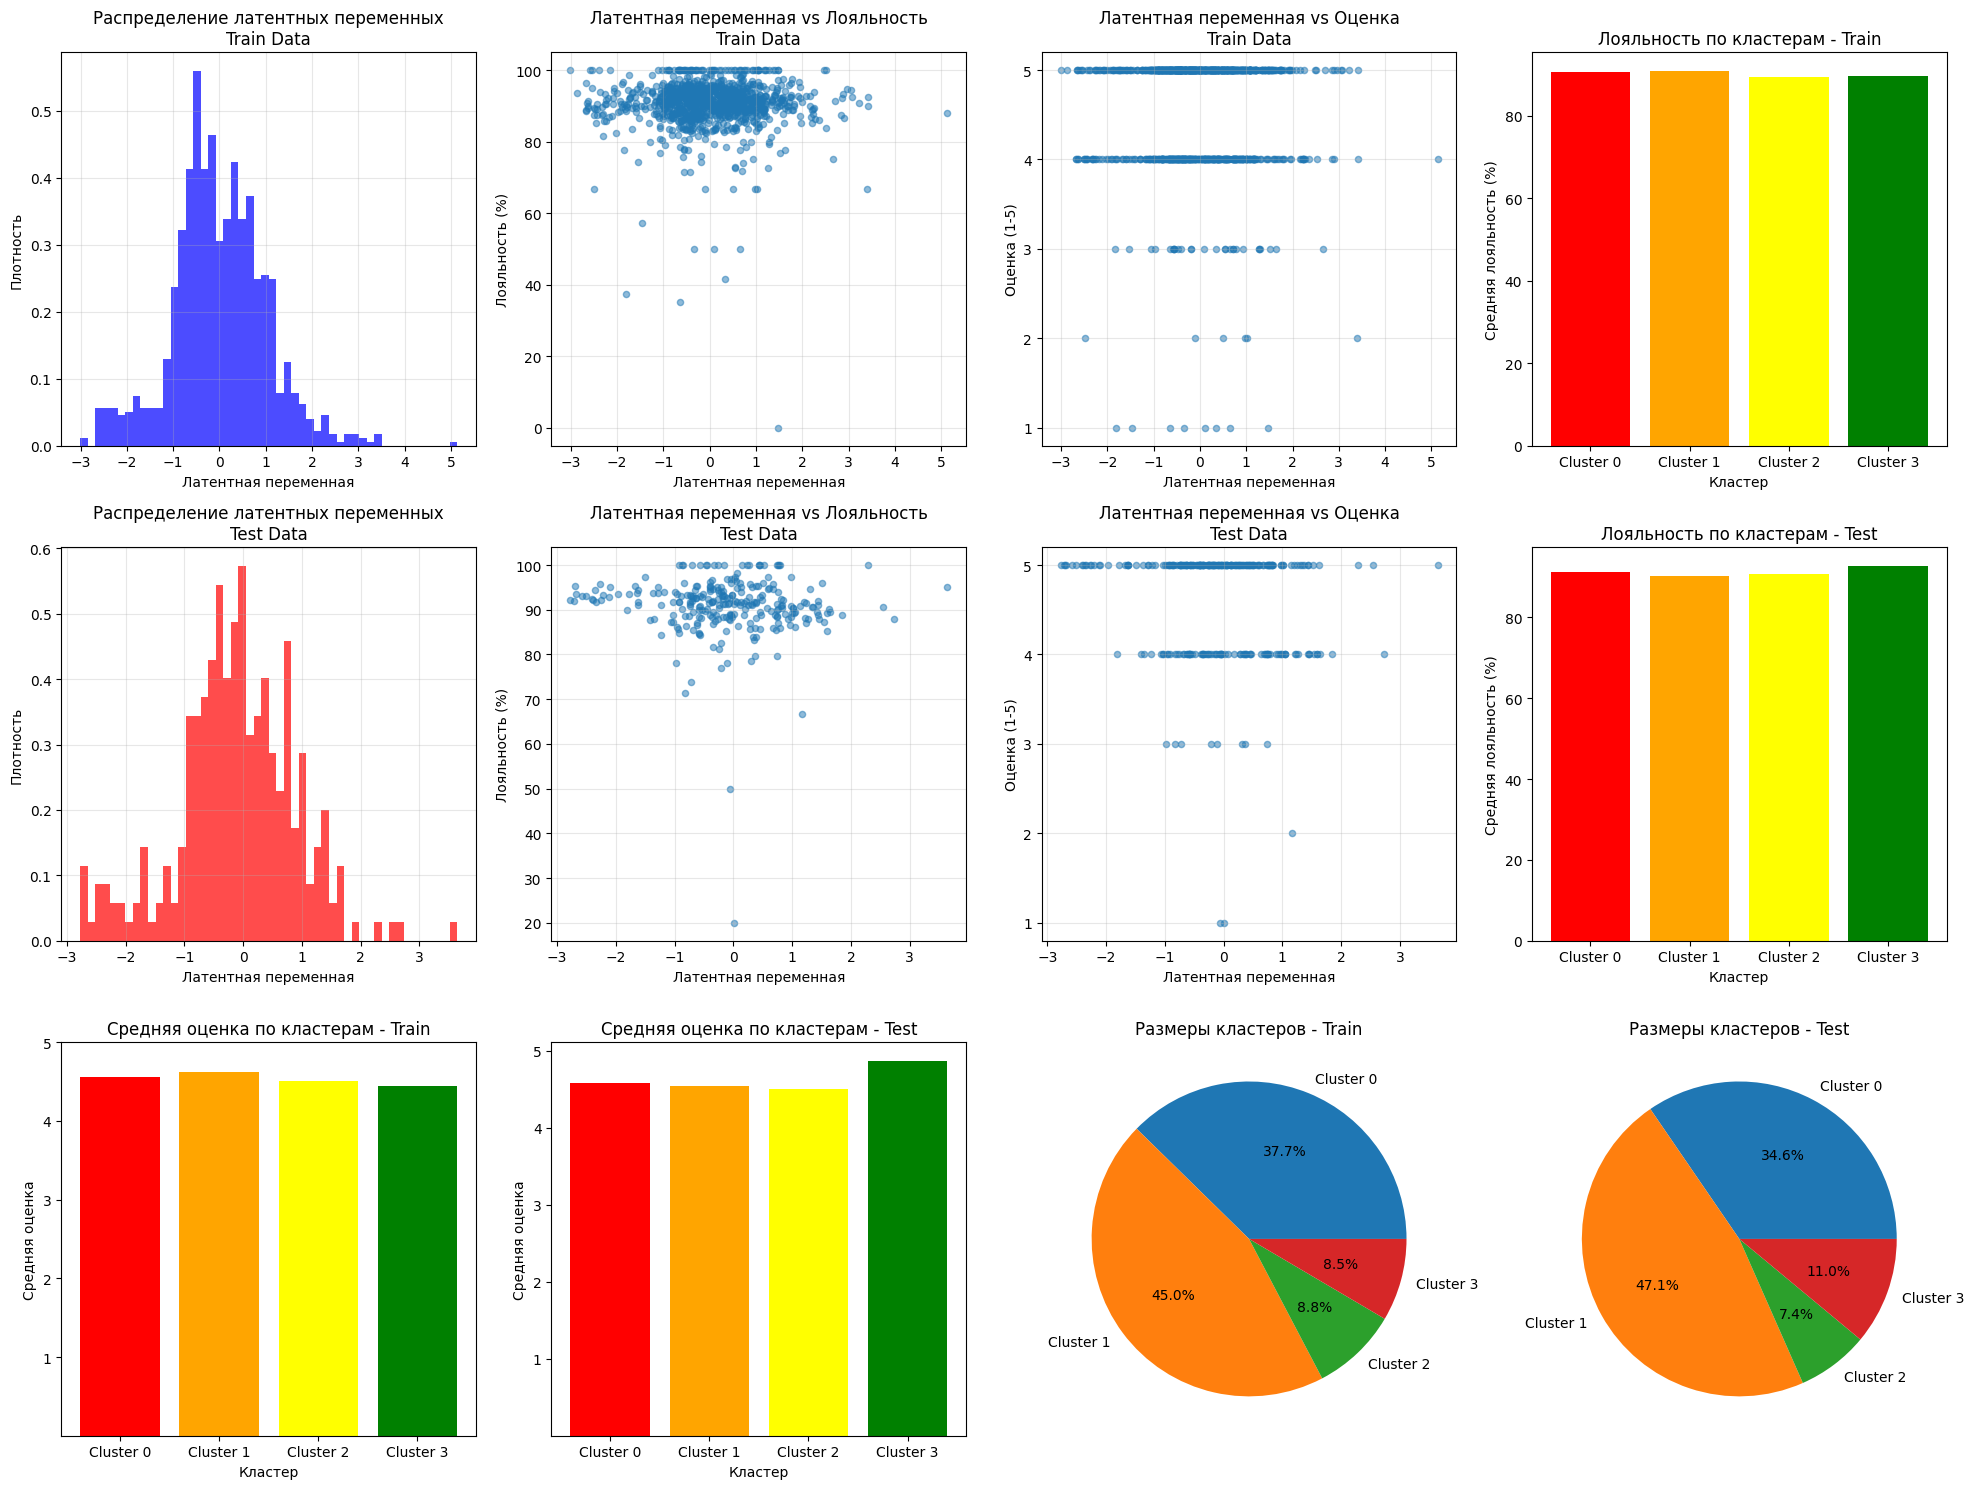


Анализ кластеров в латентном пространстве

КЛАСТЕР 0:
Размер (train): 409 samples
Размер (test): 94 samples
Диапазон латентных значений: 0.045 - 1.225
Средняя лояльность (train): 90.669%
Средняя оценка (train): 4.56
Средняя лояльность (test): 91.227%
Средняя оценка (test): 4.57

КЛАСТЕР 1:
Размер (train): 489 samples
Размер (test): 128 samples
Диапазон латентных значений: -1.207 - 0.035
Средняя лояльность (train): 90.945%
Средняя оценка (train): 4.62
Средняя лояльность (test): 90.215%
Средняя оценка (test): 4.55

КЛАСТЕР 2:
Размер (train): 96 samples
Размер (test): 20 samples
Диапазон латентных значений: 1.266 - 5.134
Средняя лояльность (train): 89.530%
Средняя оценка (train): 4.50
Средняя лояльность (test): 90.637%
Средняя оценка (test): 4.50

КЛАСТЕР 3:
Размер (train): 92 samples
Размер (test): 30 samples
Диапазон латентных значений: -3.011 - -1.245
Средняя лояльность (train): 89.665%
Средняя оценка (train): 4.45
Средняя лояльность (test): 92.759%
Средняя оценка (test): 4.87

Анализ

In [ ]:
def analyze_latent_space(model, dataloader):
    
    #Получает латентные представления для всех данных в DataLoader
    
    model.eval()
    latent_vectors = []
    reconstructions = []
    mus = []
    logvars = []
    
    with torch.no_grad():
        for batch in dataloader:
            x = batch[0]
            recon_x, mu, logvar = model(x)
            z = model.reparameterize(mu, logvar)
            
            latent_vectors.append(z.numpy())
            reconstructions.append(recon_x.numpy())
            mus.append(mu.numpy())
            logvars.append(logvar.numpy())
    
    if latent_vectors:
        latent_vectors = np.vstack(latent_vectors)
        reconstructions = np.vstack(reconstructions)
        mus = np.vstack(mus)
        logvars = np.vstack(logvars)
    else:
        latent_vectors = np.array([])
        reconstructions = np.array([])
        mus = np.array([])
        logvars = np.array([])
    
    return latent_vectors, reconstructions, mus, logvars

# Получение латентных представлений
print("Анализ латентного пространства")
latent_train, recon_train, mu_train, logvar_train = analyze_latent_space(model, train_loader)
latent_test, recon_test, mu_test, logvar_test = analyze_latent_space(model, test_loader)

print(f"Латентные представления train: {latent_train.shape}")
print(f"Латентные представления test: {latent_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

# Для гистограмм: используем первую латентную переменную
if latent_train.size > 0 and latent_train.ndim > 1:
    latent_train_1d = latent_train[:, 0] if latent_train.shape[1] > 0 else latent_train.flatten()
elif latent_train.size > 0:
    latent_train_1d = latent_train.flatten()
else:
    latent_train_1d = np.array([])

if latent_test.size > 0 and latent_test.ndim > 1:
    latent_test_1d = latent_test[:, 0] if latent_test.shape[1] > 0 else latent_test.flatten()
elif latent_test.size > 0:
    latent_test_1d = latent_test.flatten()
else:
    latent_test_1d = np.array([])

print(f"\nРазмерности для визуализации:")
print(f"latent_train_1d shape: {latent_train_1d.shape}")
print(f"latent_test_1d shape: {latent_test_1d.shape}")

# Проверяем и исправляем размерности
if len(latent_train_1d) != len(y_train):
    print(f"\nВнимание: Размерности latent_train_1d и y_train не совпадают!")
    print(f"latent_train_1d: {len(latent_train_1d)}, y_train: {len(y_train)}")
    min_len = min(len(latent_train_1d), len(y_train))
    latent_train_1d = latent_train_1d[:min_len]
    y_train = y_train[:min_len]
    X_train_vis = X_train[:min_len]
    print(f"Обрезаны данные до {min_len} элементов")

if len(latent_test_1d) != len(y_test):
    print(f"Внимание: Размерности latent_test_1d и y_test не совпадают!")
    print(f"latent_test_1d: {len(latent_test_1d)}, y_test: {len(y_test)}")
    min_len = min(len(latent_test_1d), len(y_test))
    latent_test_1d = latent_test_1d[:min_len]
    y_test = y_test[:min_len]
    X_test_vis = X_test[:min_len]
    print(f"Обрезаны данные до {min_len} элементов")

# Кластеризация в латентном пространстве (если есть данные)
if latent_train.size > 0:
    kmeans = KMeans(n_clusters=4, random_state=42)
    clusters_train = kmeans.fit_predict(latent_train)
    clusters_test = kmeans.predict(latent_test) if latent_test.size > 0 else np.array([])
else:
    print("Нет данных для кластеризации")
    clusters_train = np.array([])
    clusters_test = np.array([])

# Функция для перевода лояльности в пятибалльную систему
def loyalty_to_grade(loyalty_percent):
    # 0-60% -> 1, 60-70% -> 2, 70-80% -> 3, 80-90% -> 4, 90-100% -> 5
    if loyalty_percent < 60:
        return 1
    elif loyalty_percent < 70:
        return 2
    elif loyalty_percent < 80:
        return 3
    elif loyalty_percent < 90:
        return 4
    else:
        return 5

# Преобразование лояльности в пятибалльную систему
grades_train = np.array([loyalty_to_grade(y) for y in y_train])
grades_test = np.array([loyalty_to_grade(y) for y in y_test])

print(f"\nПятибалльная система:")
print(f"Train grades distribution: {np.bincount(grades_train)}")
print(f"Test grades distribution: {np.bincount(grades_test)}")

# Визуализация результатов (только если есть данные)
if latent_train_1d.size > 0 and latent_test_1d.size > 0:
    plt.figure(figsize=(20, 15))

    # Распределение латентных переменных - Train
    plt.subplot(3, 4, 1)
    plt.hist(latent_train_1d, bins=50, alpha=0.7, color='blue', density=True)
    plt.xlabel('Латентная переменная')
    plt.ylabel('Плотность')
    plt.title('Распределение латентных переменных\nTrain Data')
    plt.grid(True, alpha=0.3)

    # Латентные переменные vs Лояльность - Train
    plt.subplot(3, 4, 2)
    plt.scatter(latent_train_1d, y_train, alpha=0.5, s=20)
    plt.xlabel('Латентная переменная')
    plt.ylabel('Лояльность (%)')
    plt.title('Латентная переменная vs Лояльность\nTrain Data')
    plt.grid(True, alpha=0.3)

    # Латентные переменные vs Оценка - Train
    plt.subplot(3, 4, 3)
    plt.scatter(latent_train_1d, grades_train, alpha=0.5, s=20)
    plt.xlabel('Латентная переменная')
    plt.ylabel('Оценка (1-5)')
    plt.title('Латентная переменная vs Оценка\nTrain Data')
    plt.grid(True, alpha=0.3)
    plt.yticks([1, 2, 3, 4, 5])

    # Распределение лояльности по кластерам - Train
    plt.subplot(3, 4, 4)
    cluster_retention = []
    cluster_sizes = []
    cluster_ranges = []

    if clusters_train.size > 0:
        for i in range(4):
            cluster_mask = clusters_train == i
            cluster_data = latent_train[cluster_mask]
            if len(y_train[cluster_mask]) > 0:
                cluster_retention.append(y_train[cluster_mask].mean())
            else:
                cluster_retention.append(0)
            cluster_sizes.append(np.sum(cluster_mask))
            if cluster_data.shape[0] > 0:
                cluster_ranges.append((cluster_data.min(), cluster_data.max()))
            else:
                cluster_ranges.append((0, 0))
    else:
        cluster_retention = [0, 0, 0, 0]
        cluster_sizes = [0, 0, 0, 0]
        cluster_ranges = [(0, 0), (0, 0), (0, 0), (0, 0)]

    plt.bar(range(4), cluster_retention, color=['red', 'orange', 'yellow', 'green'])
    plt.xlabel('Кластер')
    plt.ylabel('Средняя лояльность (%)')
    plt.title('Лояльность по кластерам - Train')
    plt.xticks(range(4), [f'Cluster {i}' for i in range(4)])

    # Распределение латентных переменных - Test
    plt.subplot(3, 4, 5)
    plt.hist(latent_test_1d, bins=50, alpha=0.7, color='red', density=True)
    plt.xlabel('Латентная переменная')
    plt.ylabel('Плотность')
    plt.title('Распределение латентных переменных\nTest Data')
    plt.grid(True, alpha=0.3)

    # Латентные переменные vs Лояльность - Test
    plt.subplot(3, 4, 6)
    plt.scatter(latent_test_1d, y_test, alpha=0.5, s=20)
    plt.xlabel('Латентная переменная')
    plt.ylabel('Лояльность (%)')
    plt.title('Латентная переменная vs Лояльность\nTest Data')
    plt.grid(True, alpha=0.3)

    # Латентные переменные vs Оценка - Test
    plt.subplot(3, 4, 7)
    plt.scatter(latent_test_1d, grades_test, alpha=0.5, s=20)
    plt.xlabel('Латентная переменная')
    plt.ylabel('Оценка (1-5)')
    plt.title('Латентная переменная vs Оценка\nTest Data')
    plt.grid(True, alpha=0.3)
    plt.yticks([1, 2, 3, 4, 5])

    # Распределение лояльности по кластерам - Test
    plt.subplot(3, 4, 8)
    test_cluster_retention = []
    if clusters_test.size > 0:
        for i in range(4):
            cluster_mask = clusters_test == i
            if np.sum(cluster_mask) > 0 and len(y_test[cluster_mask]) > 0:
                test_cluster_retention.append(y_test[cluster_mask].mean())
            else:
                test_cluster_retention.append(np.nan)
    else:
        test_cluster_retention = [np.nan, np.nan, np.nan, np.nan]

    plt.bar(range(4), test_cluster_retention, color=['red', 'orange', 'yellow', 'green'])
    plt.xlabel('Кластер')
    plt.ylabel('Средняя лояльность (%)')
    plt.title('Лояльность по кластерам - Test')
    plt.xticks(range(4), [f'Cluster {i}' for i in range(4)])

    # Средние оценки по кластерам - Train
    plt.subplot(3, 4, 9)
    cluster_grades = []
    if clusters_train.size > 0:
        for i in range(4):
            cluster_mask = clusters_train == i
            if len(grades_train[cluster_mask]) > 0:
                cluster_grades.append(grades_train[cluster_mask].mean())
            else:
                cluster_grades.append(0)
    else:
        cluster_grades = [0, 0, 0, 0]

    plt.bar(range(4), cluster_grades, color=['red', 'orange', 'yellow', 'green'])
    plt.xlabel('Кластер')
    plt.ylabel('Средняя оценка')
    plt.title('Средняя оценка по кластерам - Train')
    plt.xticks(range(4), [f'Cluster {i}' for i in range(4)])
    plt.yticks([1, 2, 3, 4, 5])

    # Средние оценки по кластерам - Test
    plt.subplot(3, 4, 10)
    test_cluster_grades = []
    if clusters_test.size > 0:
        for i in range(4):
            cluster_mask = clusters_test == i
            if np.sum(cluster_mask) > 0 and len(grades_test[cluster_mask]) > 0:
                test_cluster_grades.append(grades_test[cluster_mask].mean())
            else:
                test_cluster_grades.append(np.nan)
    else:
        test_cluster_grades = [np.nan, np.nan, np.nan, np.nan]

    plt.bar(range(4), test_cluster_grades, color=['red', 'orange', 'yellow', 'green'])
    plt.xlabel('Кластер')
    plt.ylabel('Средняя оценка')
    plt.title('Средняя оценка по кластерам - Test')
    plt.xticks(range(4), [f'Cluster {i}' for i in range(4)])
    plt.yticks([1, 2, 3, 4, 5])

    # Размеры кластеров - Train
    plt.subplot(3, 4, 11)
    plt.pie(cluster_sizes, labels=[f'Cluster {i}' for i in range(4)], autopct='%1.1f%%')
    plt.title('Размеры кластеров - Train')

    # Размеры кластеров - Test
    plt.subplot(3, 4, 12)
    test_cluster_sizes = [np.sum(clusters_test == i) for i in range(4)] if clusters_test.size > 0 else [0, 0, 0, 0]
    plt.pie(test_cluster_sizes, labels=[f'Cluster {i}' for i in range(4)], autopct='%1.1f%%')
    plt.title('Размеры кластеров - Test')

    plt.tight_layout()
    plt.show()
else:
    print("Недостаточно данных для визуализации")

# Дополнительный анализ: характеристики кластеров
if clusters_train.size > 0:
    print("\nАнализ кластеров в латентном пространстве")

    for i in range(4):
        train_mask = clusters_train == i
        test_mask = clusters_test == i if clusters_test.size > 0 else np.array([False] * len(latent_test_1d))
        
        print(f"\nКЛАСТЕР {i}:")
        print(f"Размер (train): {np.sum(train_mask)} samples")
        print(f"Размер (test): {np.sum(test_mask)} samples")
        print(f"Диапазон латентных значений: {cluster_ranges[i][0]:.3f} - {cluster_ranges[i][1]:.3f}")
        print(f"Средняя лояльность (train): {cluster_retention[i]:.3f}%")
        print(f"Средняя оценка (train): {cluster_grades[i]:.2f}")
        if i < len(test_cluster_retention) and not np.isnan(test_cluster_retention[i]):
            print(f"Средняя лояльность (test): {test_cluster_retention[i]:.3f}%")
        else:
            print(f"Средняя лояльность (test): нет данных")
        if i < len(test_cluster_grades) and not np.isnan(test_cluster_grades[i]):
            print(f"Средняя оценка (test): {test_cluster_grades[i]:.2f}")
        else:
            print(f"Средняя оценка (test): нет данных")

# Анализ качества реконструкции
print("\nАнализ качества реконструкции")

# Вычисление MSE для реконструкции
if X_train.shape[0] == recon_train.shape[0]:
    mse_train = np.mean((X_train - recon_train) ** 2)
    print(f"Среднеквадратичная ошибка реконструкции Train: {mse_train:.4f}")
else:
    print("Несовпадение размеров для MSE train")

if X_test.shape[0] == recon_test.shape[0]:
    mse_test = np.mean((X_test - recon_test) ** 2)
    print(f"Среднеквадратичная ошибка реконструкции Test: {mse_test:.4f}")
else:
    print("Несовпадение размеров для MSE test")

# Корреляционный анализ
print("\nКорреляционный анализ")

if latent_train_1d.size > 0 and len(latent_train_1d) == len(y_train):
    corr_train = np.corrcoef(latent_train_1d, y_train)[0, 1]
    corr_train_grade = np.corrcoef(latent_train_1d, grades_train)[0, 1]
    print(f"Корреляция латентной переменной с лояльностью (Train): {corr_train:.4f}")
    print(f"Корреляция латентной переменной с оценкой (Train): {corr_train_grade:.4f}")
else:
    print("Недостаточно данных для расчета корреляции Train")

if latent_test_1d.size > 0 and len(latent_test_1d) == len(y_test):
    corr_test = np.corrcoef(latent_test_1d, y_test)[0, 1]
    corr_test_grade = np.corrcoef(latent_test_1d, grades_test)[0, 1]
    print(f"Корреляция латентной переменной с лояльностью (Test): {corr_test:.4f}")
    print(f"Корреляция латентной переменной с оценкой (Test): {corr_test_grade:.4f}")
else:
    print("Недостаточно данных для расчета корреляции Test")

# Рекомендации по сегментам на основе кластеров
print("\nРекомендации по сегментам:")

if clusters_train.size > 0:
    cluster_info = []
    for i in range(4):
        train_mask = clusters_train == i
        if len(y_train[train_mask]) > 0:
            avg_loyalty = y_train[train_mask].mean()
            avg_grade = grades_train[train_mask].mean()
            cluster_info.append((i, avg_loyalty, avg_grade))
    
    # Сортировка кластеров по средней лояльности
    cluster_info.sort(key=lambda x: x[1])
    
    recommendations = {
        0: "Проблемные студенты",
        1: "Рискованные студенты", 
        2: "Стандартные студенты",
        3: "Перспективные студенты"
    }
    
    for idx, (cluster_id, avg_loyalty, avg_grade) in enumerate(cluster_info):
        segment_name = list(recommendations.keys())[idx]
        print(f"Кластер {cluster_id} (средняя лояльность: {avg_loyalty:.1f}%, оценка: {avg_grade:.1f}) -> {recommendations[segment_name]}")

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.cluster import KMeans

FEATURE_NAMES = {
    0: "Активность на платформе",
    1: "Успеваемость", 
    2: "Посещаемость занятий",
    3: "Вовлеченность в сообщество",
    4: "Использование доп. материалов",
    5: "Качество выполненных работ",
    6: "Продолжительность обучения"
}

FEATURE_DESCRIPTIONS = {
    0: "Частота логинов и активность на образовательной платформе",
    1: "Средний балл по курсам и тестам",
    2: "Регулярность посещения онлайн/офлайн занятий", 
    3: "Участие в форумах, группах, мероприятиях",
    4: "Использование дополнительных материалов и ресурсов",
    5: "Средняя оценка за домашние задания и проекты",
    6: "Общее время обучения на платформе"
}

class StudentVAE(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim=16, latent_dim=1):
        super(StudentVAE, self).__init__()
        
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        
        # Энкодер
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(input_dim, hidden_dim),
            torch.nn.ReLU(),
        )
        
        # Латентное пространство
        self.fc_mu = torch.nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = torch.nn.Linear(hidden_dim, latent_dim)
        
        # Декодер
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(latent_dim, hidden_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_dim, input_dim)
        )
        
    def encode(self, x):
        h = self.encoder(x)
        return self.fc_mu(h), self.fc_logvar(h)
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z):
        return self.decoder(z)
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


def load_trained_model(model_path, input_dim=9):

    # Загрузка обученной модели

    model = StudentVAE(input_dim=input_dim, hidden_dim=16, latent_dim=1)
    checkpoint = torch.load(model_path, map_location='cpu')
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    return model

def create_student_from_features(**kwargs):
    
    # Создает студента с 7 основными признаками и дополняет до 9 признаков
    # недостающими значениями (на основе средних значений из реальных данных)
    
    # Значения по умолчанию (средние по пятибалльной шкале)
    main_features = np.array([3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0])  # Среднее значение = 3
    
    for feature_name, value in kwargs.items():
        if not (1.0 <= value <= 5.0):
            raise ValueError(f"Значение должно быть от 1 до 5, получено: {value}")
            
        if feature_name in ["activity", "activity_score"]:
            main_features[0] = value
        elif feature_name in ["performance", "grades"]:
            main_features[1] = value
        elif feature_name in ["attendance", "participation"]:
            main_features[2] = value
        elif feature_name in ["engagement", "community"]:
            main_features[3] = value
        elif feature_name in ["materials", "resources"]:
            main_features[4] = value
        elif feature_name in ["quality", "homework"]:
            main_features[5] = value
        elif feature_name in ["duration", "length"]:
            main_features[6] = value
    
    # Дополнение до 9 признаков - добавляем средние значения для enrollment_change и assessment_rate
    # Эти признаки были созданы из реальных данных, поэтому используем типичные значения
    enrollment_change = 1.0  # Среднее изменение набора ~1.0 (стабильный набор)
    assessment_rate = 0.8    # Средняя доля оцененных работ ~80%
    
    # Объединяем все признаки
    full_features = np.concatenate([main_features, [enrollment_change, assessment_rate]])
    
    return full_features

def analyze_student_profile(student_data):
    
    # Анализ профиля студента (работает только с первыми 7 признаками)
    
    # Если передано 9 признаков, берeм только первые 7
    if len(student_data) > 7:
        main_data = student_data[:7]
    else:
        main_data = student_data
    
    avg_score = np.mean(main_data)
    min_score = np.min(main_data)
    max_score = np.max(main_data)
    weak_features = np.sum(main_data < 2.0)  # Количество слабых признаков (оценка < 2)
    strong_features = np.sum(main_data > 4.0)  # Количество сильных признаков (оценка > 4)
    
    return {
        'avg_score': avg_score,
        'min_score': min_score,
        'max_score': max_score,
        'weak_features_count': weak_features,
        'strong_features_count': strong_features,
        'overall_profile': get_overall_profile(avg_score, weak_features, strong_features)
    }

def get_overall_profile(avg_score, weak_features, strong_features):

    if weak_features >= 4:
        return "Критический"
    elif avg_score < 2.0:
        return "Низкий"
    elif avg_score < 2.7:
        return "Ниже среднего"
    elif avg_score < 3.3:
        return "Средний"
    elif avg_score < 4.0:
        return "Выше среднего"
    else:
        return "высокий"

def predict_student_segment(model, student_data, student_name="Студент"):
    
    model.eval()
    with torch.no_grad():
        # Проверка: должно быть 9 признаков
        if len(student_data) != 9:
            raise ValueError(f"Ожидалось 9 признаков, получено: {len(student_data)}")
        
        # Нормализация данных для VAE
        # Первые 7 признаков: гипотетические метрики (1-5) → преобразуем в [-1.6, +1.6]
        normalized_main = (student_data[:7] - 3.0) * 0.8
        
        # Последние 2 признака: enrollment_change и assessment_rate
        # enrollment_change: обычно в диапазоне [0.5, 1.5] → нормализуем как (x - 1.0) / 0.5
        # assessment_rate: обычно в диапазоне [0.0, 1.0] → нормализуем как (x - 0.5) / 0.5
        normalized_enrollment = (student_data[7] - 1.0) / 0.5
        normalized_assessment = (student_data[8] - 0.5) / 0.5
        
        normalized_data = np.concatenate([normalized_main, [normalized_enrollment, normalized_assessment]])
        
        student_tensor = torch.FloatTensor(normalized_data).unsqueeze(0)
        recon, mu, logvar = model(student_tensor)
        latent_value = mu.item()
        
        # Анализ профиля студента (только по первым 7 признакам)
        profile = analyze_student_profile(student_data[:7])
        avg_score = profile['avg_score']
        weak_features = profile['weak_features_count']
        min_score = profile['min_score']
        strong_features = profile['strong_features_count']
        
        if weak_features >= 4 or min_score < 1.5:
            # Много слабых признаков или хотя бы один очень слабый
            cluster = 0
            segment_name = "Проблемные студенты"
            risk_level = "Высокий риск"
            base_loyalty = 82.0
            description = "Студенты с критически низкими показателями по ключевым метрикам"
            actions = [
                "- Срочные персональные консультации",
                "- Индивидуальный план восстановления",
                "- Повышенное внимание куратора",
                "- Специальные мотивационные программы"
            ]
        elif avg_score < 2.5:
            cluster = 3  
            segment_name = "Рискованные студенты"
            risk_level = "Средний риск"
            base_loyalty = 86.0
            description = "Студенты с нестабильными или низкими показателями"
            actions = [
                "- Групповые занятия и воркшопы",
                "- Регулярный мониторинг прогресса",
                "- Дополнительные учебные материалы",
                "- Мотивационные рассылки"
            ]
        elif avg_score > 4.0 and strong_features >= 3 and min_score > 2.0:
            cluster = 2
            segment_name = "Перспективные студенты" 
            risk_level = "Очень низкий риск"
            base_loyalty = 94.0
            description = "Студенты со стабильно высокими показателями"
            actions = [
                "- Премиальные программы обучения",
                "- Реферальные бонусы",
                "- Участие в менторских программах",
                "- Приоритетный доступ к новым курсам"
            ]
        else:
            cluster = 1
            segment_name = "Обычные студенты"
            risk_level = "Низкий риск"
            base_loyalty = 90.0
            description = "Студенты со стабильными средними показателями"
            actions = [
                "- Стандартные программы обучения",
                "- Групповые активности",
                "- Регулярные опросы удовлетворенности",
                "- Доступ ко всем базовым ресурсам"
            ]
        
        # Лояльность на основе латентного значения
        loyalty_adjustment = latent_value * 1.5  
        predicted_loyalty = max(75, min(98, base_loyalty + loyalty_adjustment))
        
        # Анализ сильных и слабых сторон
        feature_analysis = analyze_features_detailed(student_data[:7])
        
        # ВАЖНО: ВОЗВРАЩАЕМ РЕЗУЛЬТАТ!
        return {
            'student_name': student_name,
            'latent_value': latent_value,
            'cluster': cluster,
            'segment_name': segment_name,
            'risk_level': risk_level,
            'predicted_loyalty': round(predicted_loyalty, 1),
            'description': description,
            'recommended_actions': actions,
            'profile_analysis': profile,
            'feature_analysis': feature_analysis,
            'reconstruction': recon.squeeze().numpy()
        }

def analyze_features_detailed(student_data):

    analysis = {
        'strengths': [],
        'weaknesses': [],
        'neutral': [],
        'recommendations': []
    }
    
    for i, value in enumerate(student_data):
        feature_name = FEATURE_NAMES[i]
        
        if value > 4.0:
            analysis['strengths'].append(f"{feature_name}: {value:.1f} (отлично)")
        elif value > 3.5:
            analysis['strengths'].append(f"{feature_name}: {value:.1f} (хорошо)")
        elif value < 2.0:
            analysis['weaknesses'].append(f"{feature_name}: {value:.1f} (критически низкий)")
        elif value < 2.5:
            analysis['weaknesses'].append(f"{feature_name}: {value:.1f} (ниже среднего)")
        else:
            analysis['neutral'].append(f"{feature_name}: {value:.1f} (удовлетворительно)")
    
    # Рекомендации на основе анализа
    if len(analysis['weaknesses']) >= 3:
        analysis['recommendations'].append("Требуется комплексная программа поддержки")
    if any("Активность" in strength for strength in analysis['strengths']):
        analysis['recommendations'].append("Можно привлекать к менторской деятельности")
    if any("Успеваемость" in weakness for weakness in analysis['weaknesses']):
        analysis['recommendations'].append("Рекомендуются дополнительные занятия")
    
    return analysis

def display_student_prediction(prediction):

    print(f"\n{''}")
    print(f"{prediction['student_name']}")
    print(f"{''}")
    
    print(f"\nСегмент: {prediction['segment_name']}")
    print(f"Латентный показатель: {prediction['latent_value']:.3f}")
    print(f"Уровень риска: {prediction['risk_level']}")
    print(f"Прогнозируемая лояльность: {prediction['predicted_loyalty']}%")
    print(f"{prediction['description']}")
    
    # Профиль студента
    profile = prediction['profile_analysis']
    print(f"\nОбщий профиль: {profile['overall_profile']}")
    print(f"Средний балл: {profile['avg_score']:.1f}")
    print(f"Сильных сторон: {profile['strong_features_count']}")
    print(f"Слабых сторон: {profile['weak_features_count']}")
    
    print(f"\nРекомендации для повышения лояльности:")
    for action in prediction['recommended_actions']:
        print(f"{action}")
    
    # Анализ признаков
    analysis = prediction['feature_analysis']
    if analysis['strengths']:
        print(f"\nСильные стороны:")
        for strength in analysis['strengths']:
            print(f" - {strength}")
    
    if analysis['weaknesses']:
        print(f"\nСлабые стороны:")
        for weakness in analysis['weaknesses']:
            print(f" - {weakness}")
    
    if analysis['neutral']:
        print(f"\nУдовлетворительные показатели:")
        for neutral in analysis['neutral'][:3]:
            print(f" - {neutral}")
    
    if analysis['recommendations']:
        print(f"\nДополнительные рекомендации:")
        for rec in analysis['recommendations']:
            print(f" - {rec}")


def predict_multiple_students(model, students_data, student_names=None):

    if student_names is None:
        student_names = [f"Студент {i+1}" for i in range(len(students_data))]
    
    results = []
    for i, (student_data, name) in enumerate(zip(students_data, student_names)):
        result = predict_student_segment(model, student_data, name)
        results.append(result)
    
    return results

def display_batch_predictions(predictions):

    
    summary = {
        "Проблемные студенты": 0,
        "Рискованные студенты": 0, 
        "Обычные студенты": 0,
        "Перспективные студенты": 0
    }
    
    for pred in predictions:
        summary[pred['segment_name']] += 1
        print(f"\n{pred['student_name']}:")
        print(f"{pred['segment_name']}")
        print(f"Лояльность: {pred['predicted_loyalty']}%")
        print(f"Риск: {pred['risk_level']}")
        print(f"Профиль: {pred['profile_analysis']['overall_profile']}")
    
    # Сводная статистика
    print(f"\nСтатистика:")
    total_students = len(predictions)
    for segment, count in summary.items():
        percentage = (count / total_students) * 100 if total_students > 0 else 0
        print(f"   {segment}: {count} студентов ({percentage:.1f}%)")


print("Загрузка обученной модели")
model = load_trained_model('student_model_vae_best.pth')

# Пример 1: Проблемный студент (должен быть в кластере 0)
print("\n1. Проблемный студент:")
problem_student = create_student_from_features(
    activity=1.2,       # Очень низкая активность
    performance=1.0,    # Критически низкая успеваемость  
    attendance=1.5,     # Низкая посещаемость
    engagement=1.8,     # Низкая вовлеченность
    materials=2.2,      # Редко использует материалы
    quality=2.0,        # Низкое качество работ
    duration=2.5        # Короткое время обучения
)

pred1 = predict_student_segment(model, problem_student, "Алексей Петров (проблемный)")
display_student_prediction(pred1)

# Пример 2: Стандартный студент (должен быть в кластере 1)
print("\n2. Стандартный студент:")
standard_student = create_student_from_features(
    activity=3.3,       # Средняя активность
    performance=3.5,    # Хорошая успеваемость
    attendance=3.2,     # Регулярная посещаемость
    engagement=3.1,     # Умеренная вовлеченность
    materials=3.4,      # Использует материалы
    quality=3.3,        # Качество работ на уровне
    duration=3.6        # Нормальная продолжительность
)

pred2 = predict_student_segment(model, standard_student, "Мария Сидорова (обычная)")
display_student_prediction(pred2)

# Пример 3: Перспективный студент (должен быть в кластере 2)
print("\n3. Перспективный студент:")
top_student = create_student_from_features(
    activity=4.8,       # Высокая активность
    performance=5.0,    # Отличная успеваемость
    attendance=4.5,     # Идеальная посещаемость
    engagement=4.2,     # Активное участие
    materials=4.4,      # Использует все материалы
    quality=5.0,        # Высокое качество работ
    duration=4.3        # Длительное обучение
)

pred3 = predict_student_segment(model, top_student, "Дмитрий Иванов (перспективный)")
display_student_prediction(pred3)

# Пример 4: Рискованный студент (должен быть в кластере 3)
print("\n4. Рискованный студент:")
risky_student = create_student_from_features(
    activity=1.8,       # Низкая активность
    performance=3.7,    # Но хорошая успеваемость
    attendance=2.1,     # Низкая посещаемость
    engagement=2.3,     # Слабая вовлеченность
    materials=3.2,      # Использует материалы
    quality=2.4,        # Нестабильное качество
    duration=2.2        # Короткое время
)



test_students_data = [
    create_student_from_features(activity=1.0, performance=1.2, attendance=1.5, engagement=1.8, materials=2.2, quality=1.5, duration=2.0),
    create_student_from_features(activity=3.5, performance=3.3, attendance=3.1, engagement=2.8, materials=3.7, quality=2.9, duration=3.4),
    create_student_from_features(activity=4.5, performance=4.8, attendance=5.0, engagement=4.5, materials=4.8, quality=4.2, duration=4.3),
    create_student_from_features(activity=2.0, performance=2.5, attendance=1.8, engagement=2.2, materials=2.7, quality=1.9, duration=2.4),
    create_student_from_features(activity=3.8, performance=3.9, attendance=3.7, engagement=3.6, materials=3.5, quality=3.8, duration=4.1)
]

test_student_names = ["Иван Критический", "Петр Средний", "Ольга Отличница", "Сергей Рисковый", "Елена Стабильная-Перспективная"]

batch_predictions = predict_multiple_students(model, test_students_data, test_student_names)
display_batch_predictions(batch_predictions)

def interactive_student_test():

    print("Введите данные студента по пятибалльной шкале (от 1 до 5):")
    print("1: Очень низкий показатель")
    print("2: Низкий показатель")
    print("3: Средний показатель")  
    print("4: Высокий показатель")
    print("5: Очень высокий показатель")
    print("-" * 50)
    
    features = []
    for i in range(7):
        feature_name = FEATURE_NAMES[i]
        description = FEATURE_DESCRIPTIONS[i]
        while True:
            try:
                value = float(input(f"\n{feature_name}:\n{description}\nВведите оценку (1-5): "))
                if 1.0 <= value <= 5.0:
                    features.append(value)
                    break
                else:
                    print("Ошибка: значение должно быть от 1 до 5")
            except ValueError:
                print("Ошибка: введите числовое значение")
    
    student_name = input("\nВведите имя студента: ")
    
    # Создаем полный вектор из 9 признаков
    student_data = create_student_from_features(**dict(zip(
        ["activity", "performance", "attendance", "engagement", "materials", "quality", "duration"],
        features
    )))
    
    # предсказание
    prediction = predict_student_segment(model, student_data, student_name)
    display_student_prediction(prediction)
    
    return prediction


print("\n" + " ")
print("Инструкция по использованию системы")
print(" ")

print("""
1. Сегментация студентов:
   Проблемные студенты    - Критически низкие показатели (>3 признаков с оценкой < 2)
   Рискованные студенты   - Нестабильные или низкие показатели (средний балл < 2.5)
   Стандартные студенты   - Стабильные средние показатели (средний балл 2.7-3.3)  
   Перспективные студенты - Высокие показатели по всем метрикам (средний балл > 4.0)

2. Оценка признаков (пятибалльная система):
   1 : Очень низкий показатель
   2 : Низкий показатель
   3 : Средний показатель
   4 : Высокий показатель  
   5 : Очень высокий показатель

3. Рекомендации:
   Интенсивная индивидуальная поддержка
   Групповые программы и мониторинг
   Стандартные образовательные программы  
   Премиальные и менторские программы

4. Использование:
   student_data = create_student_from_features(
       activity=3.5,      # Активность на платформе
       performance=4.2,   # Успеваемость
       # остальные признаки
   )
   prediction = predict_student_segment(model, student_data, "Имя")
""")

# следующую строка для интерактивного тестирования:
# interactive_student_test()

Загрузка обученной модели

1. Проблемный студент:


Алексей Петров (проблемный)


Сегмент: Проблемные студенты
Латентный показатель: 0.501
Уровень риска: Высокий риск
Прогнозируемая лояльность: 82.8%
Студенты с критически низкими показателями по ключевым метрикам

Общий профиль: Критический
Средний балл: 1.7
Сильных сторон: 0
Слабых сторон: 4

Рекомендации для повышения лояльности:
- Срочные персональные консультации
- Индивидуальный план восстановления
- Повышенное внимание куратора
- Специальные мотивационные программы

Слабые стороны:
 - Активность на платформе: 1.2 (критически низкий)
 - Успеваемость: 1.0 (критически низкий)
 - Посещаемость занятий: 1.5 (критически низкий)
 - Вовлеченность в сообщество: 1.8 (критически низкий)
 - Использование доп. материалов: 2.2 (ниже среднего)
 - Качество выполненных работ: 2.0 (ниже среднего)

Удовлетворительные показатели:
 - Продолжительность обучения: 2.5 (удовлетворительно)

Дополнительные рекомендации:
 - Требуется комплексная программа по

In [8]:
from torchinfo import summary

model = StudentVAE(input_dim=9, hidden_dim=16, latent_dim=1)

summary(model, input_size=(32, 9)) 

Layer (type:depth-idx)                   Output Shape              Param #
StudentVAE                               [32, 9]                   --
├─Sequential: 1-1                        [32, 16]                  --
│    └─Linear: 2-1                       [32, 16]                  160
│    └─ReLU: 2-2                         [32, 16]                  --
├─Linear: 1-2                            [32, 1]                   17
├─Linear: 1-3                            [32, 1]                   17
├─Sequential: 1-4                        [32, 9]                   --
│    └─Linear: 2-3                       [32, 16]                  32
│    └─ReLU: 2-4                         [32, 16]                  --
│    └─Linear: 2-5                       [32, 9]                   153
Total params: 379
Trainable params: 379
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.01
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.00
Estimated Total Size (MB): 0.01